In [1]:
'''
Lots of plots for the Wiki-HUEs/Jammu and Kashmir paper. Not all to be included in the paper.

To export this to PDF without the plots, run the following in the command line. You'll need xelatex or xetex, and nbconvert.
jupyter nbconvert --to pdf Pageviews-edits-data-viz-Clean.ipynb --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True --TemplateExporter.exclude_input=True
'''

"\nLots of plots for the Wiki-HUEs/Jammu and Kashmir paper. Not all to be included in the paper.\n\nTo export this to PDF without the plots, run the following in the command line. You'll need xelatex or xetex, and nbconvert.\njupyter nbconvert --to pdf Pageviews-edits-data-viz-Clean.ipynb --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True --TemplateExporter.exclude_input=True\n"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime as dt
import numpy as np
import fnmatch
import os

Page views time series.
===
Log scale makes local peaks more visible. Linear scale plots are in plots/pageviews if you want to see them. Note that these are all from article creation through March 2020. Later in the notebook there are plots of only 2019, with both page views and edits time series.

In [3]:
def plotPageViews(df, articleName, language):
    '''
    Plot page views log scale
    ---
    Parameters:
    df:           the dataframe, loaded from "wiki_<lang>_pageviews_<dates>.csv" file
    articleName:  the WHOLE name of the article of interest, in English
    '''
    # color code
    if "conflict" in articleName:
        clr = "gray"
    elif "Article" in articleName:
        clr = "green"
    elif "Insurgency" in articleName:
        clr = "mediumvioletred"
    elif "Pulwama" in articleName:
        clr = "rebeccapurple"
    elif "Reorg" in articleName:
        clr = "navy"
    
    # subset dataframe
    df = df[df['article'] == articleName]
    df['ts'] = pd.to_datetime(df['date'])
    df = df.drop('date', axis=1)
    df = df.set_index('ts')

    # plot log scale page-views vs time
    df['views'].plot(linestyle='-', linewidth=1.5, color = clr)
    plt.yscale('log')
    plt.title(language + " " + articleName + " Pageviews per day log scale")
    
    
def pageViewsFname(lang):
    '''
    Quick helper that returns the name of the file that contains pageviews data for a given language.
    This will need to change when we get new data
    '''
    return "../data/pageviews/wiki_" + lang + "_pageviews_2000_thru_Mar2020.csv"

   Unnamed: 0       project           article granularity      access  \
0           0  hi.wikipedia  Kashmir conflict       daily  all-access   
1           1  hi.wikipedia  Kashmir conflict       daily  all-access   
2           2  hi.wikipedia  Kashmir conflict       daily  all-access   
3           3  hi.wikipedia  Kashmir conflict       daily  all-access   
4           4  hi.wikipedia  Kashmir conflict       daily  all-access   

        agent  views        date  
0  all-agents    104  2019-01-01  
1  all-agents    144  2019-01-02  
2  all-agents    159  2019-01-03  
3  all-agents    174  2019-01-04  
4  all-agents    145  2019-01-05  


/home/molly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


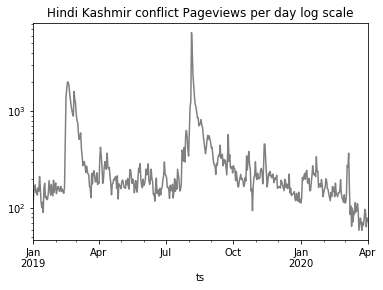

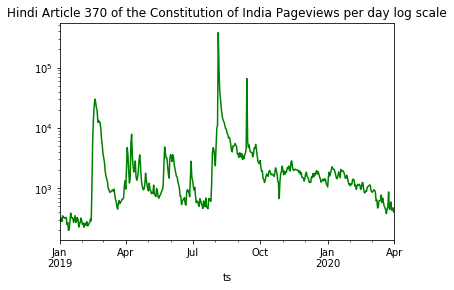

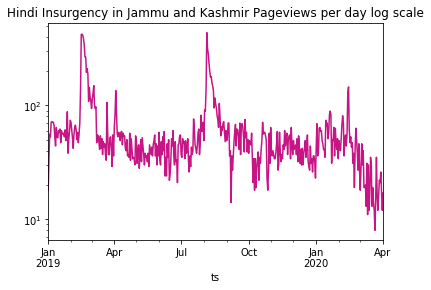

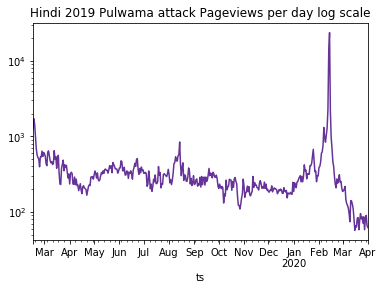

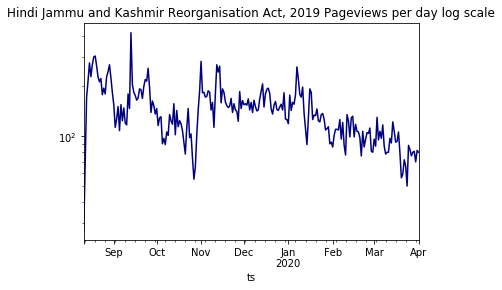

   Unnamed: 0       project           article granularity      access  \
0           0  en.wikipedia  Kashmir conflict       daily  all-access   
1           1  en.wikipedia  Kashmir conflict       daily  all-access   
2           2  en.wikipedia  Kashmir conflict       daily  all-access   
3           3  en.wikipedia  Kashmir conflict       daily  all-access   
4           4  en.wikipedia  Kashmir conflict       daily  all-access   

        agent  views        date  
0  all-agents   1233  2019-01-01  
1  all-agents   1425  2019-01-02  
2  all-agents   1558  2019-01-03  
3  all-agents   1522  2019-01-04  
4  all-agents   1447  2019-01-05  


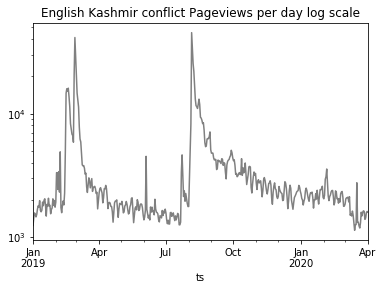

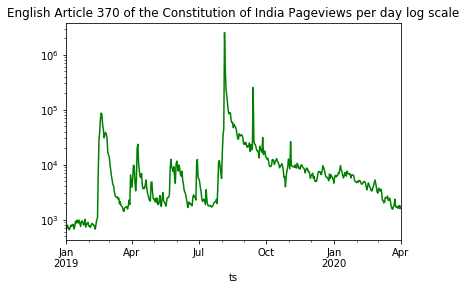

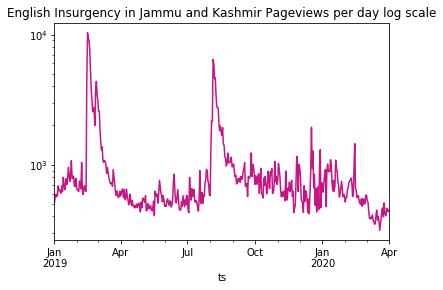

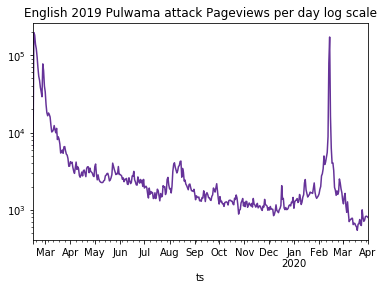

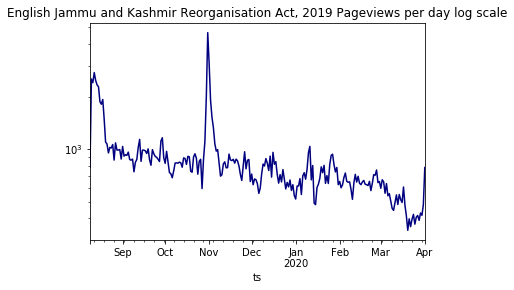

   Unnamed: 0       project           article granularity      access  \
0           0  ur.wikipedia  Kashmir conflict       daily  all-access   
1           1  ur.wikipedia  Kashmir conflict       daily  all-access   
2           2  ur.wikipedia  Kashmir conflict       daily  all-access   
3           3  ur.wikipedia  Kashmir conflict       daily  all-access   
4           4  ur.wikipedia  Kashmir conflict       daily  all-access   

        agent  views        date  
0  all-agents      9  2019-01-01  
1  all-agents     19  2019-01-02  
2  all-agents     12  2019-01-03  
3  all-agents     12  2019-01-04  
4  all-agents     13  2019-01-05  


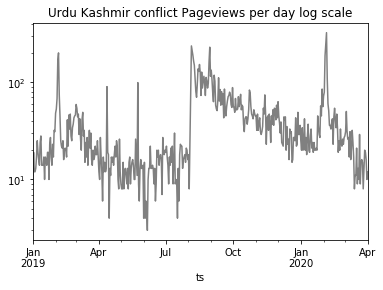

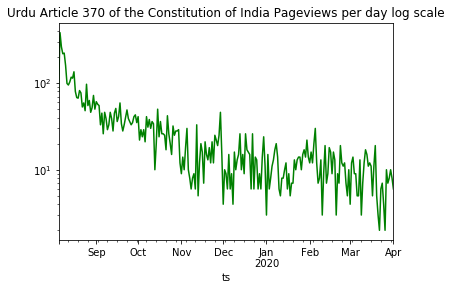

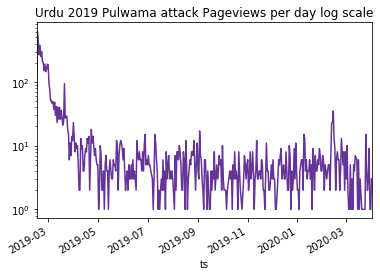

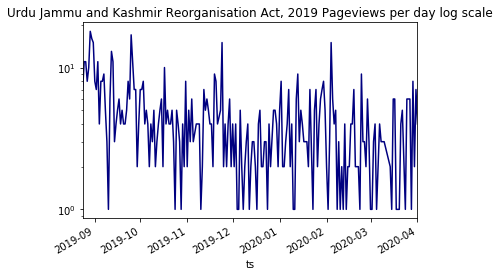

In [4]:
for filepair in [(pageViewsFname("hi"), "Hindi"), (pageViewsFname("en"), "English"),\
                 (pageViewsFname("ur"), "Urdu")]:
    
    pvdf = pd.read_csv(filepair[0])
    print(pvdf.head())
    #print(pvdf.head())
    articlesList = ["Kashmir conflict", "Article 370 of the Constitution of India",\
                    "Insurgency in Jammu and Kashmir", \
                    "2019 Pulwama attack", "Jammu and Kashmir Reorganisation Act, 2019"]
    
    for article in articlesList:
        
        if (filepair[1] == "Urdu") &  ("Insurgency" in article):
            continue # there is no Insurgency article in Urdu
            
        plotPageViews(pvdf, article, filepair[1])
        
        plt.show()


In [5]:
def findfile(prefix):
    '''
    This is for finding the file you want, no matter the date in the filename
    Assumes the folder has only the most recent files in it
    '''
    for f in os.listdir(mypath):
        if fnmatch.fnmatch(f, prefix + '_*.json'):
            return f

In [6]:
# Helper function for time-lagged cross-correlation (how we measure editing response time)

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """ 
    return datax.corr(datay.shift(lag))


In [7]:
def corrPlot(views, edits, what):
    '''
    TIME-LAGGED CROSS-CORRELATION
    -2 week to 2 week lag
    Correlation computed between views per day and edits per day
    We "know" that edits don't lead pageviews, so in a perfect world there would be no correlation to the right of
    center. Interesting results to follow!
    '''
    rs = [crosscorr(views, edits, lag) for lag in range(int(-14),int(15))]
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'Offset = {offset} days\nviews leads <> edits leads',ylim=[0,1],xlim=[0,28], xlabel='Offset',\
           ylabel='Pearson r')
    # TICKS are -14 to 14: the offsets we set
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.set_xticklabels([-14, -7, 0, 7, 14]);
    plt.suptitle(what + " correlation between pageviews and edits", y=1.1)
    plt.legend()
    

def getEdits(filepath):
    '''
    Get edits dataframe given filepath. File must be json.
    '''
    with open(filepath) as thefile:
            data = json.load(thefile)
            dfEdits = pd.DataFrame(data)
    
    dfEdits['date'] = pd.to_datetime(dfEdits['timestamp'])
    dfEdits = dfEdits.set_index('date')
    dfEdits = dfEdits.groupby(pd.Grouper(freq='D', level=0)).count()

    # pandas timezone weirdness requires that we do this
    dfEdits.index = dfEdits.index.date

    # total edits = edits by registered users + "anonymous" edits (IP addresses and people who wish to remain anon)
    if 'anon' in dfEdits.columns:
        dfEdits['total'] = dfEdits['user'] + dfEdits['anon']
    else: # Pulwama Urdu (and maybe others) don't have the anon field
        dfEdits['total'] = dfEdits['user']
        
    newpath = "DAILY_" + filepath[18:]
    dfEdits.to_csv(newpath.replace('json', 'csv'))
    
    return dfEdits


def getViews(filepath, article):
    '''
    Get pageviews dataframe given filepath. File must be csv.
    '''
    df = pd.read_csv(filepath)
    df = df[df['article'] == article]

    df['ts'] = pd.to_datetime(df['date'])
    df = df.drop('date', axis=1)
    df = df.set_index('ts')
    
    return df

Edits per day timeseries
===

Also from article creation through March 2020. The original three articles:
* Kashmir Conflict
* Article 370 of the Constitution of India
* Insurgency in Jammu and Kashmir

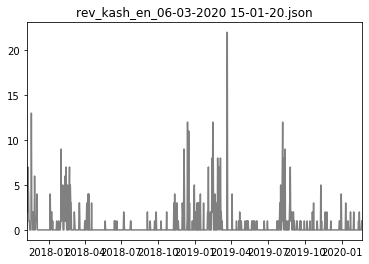

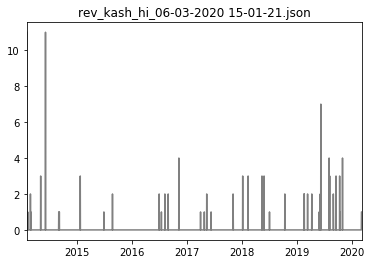

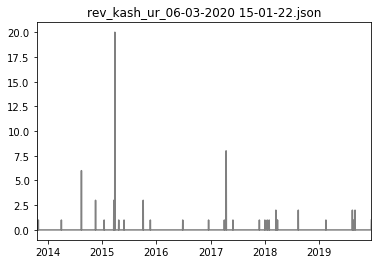

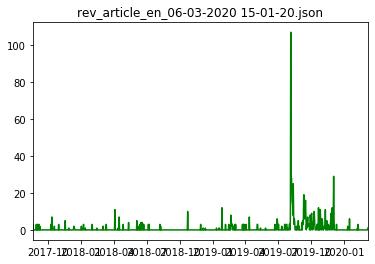

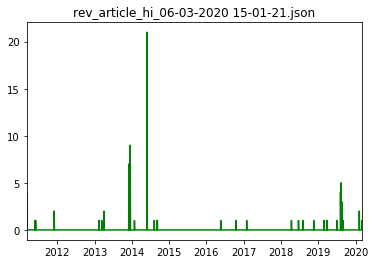

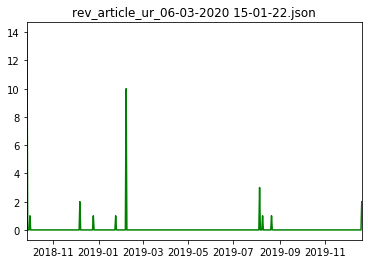

            user  timestamp  size  comment  total
2012-08-13     1          1     1        1      1
2012-08-14     0          0     0        0      0
2012-08-15     0          0     0        0      0
2012-08-16     0          0     0        0      0
2012-08-17     0          0     0        0      0


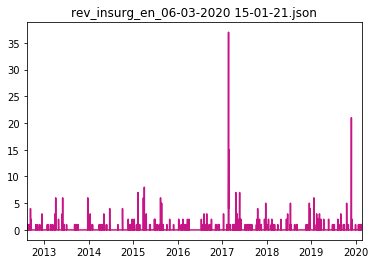

            user  timestamp  size  comment  anon  total
2011-04-14     1          1     1        1     0      1
2011-04-15     0          0     0        0     0      0
2011-04-16     0          0     0        0     0      0
2011-04-17     0          0     0        0     0      0
2011-04-18     0          0     0        0     0      0


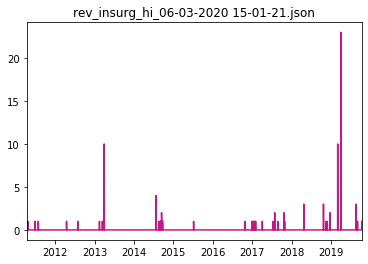

In [8]:
# THE OG ARTICLES

mypath = "../data/revisions/" # Do Not Change This

for file in [findfile("rev_kash_en"), findfile("rev_kash_hi"), findfile("rev_kash_ur")]:
        edits = getEdits(mypath + file)
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="gray")
        plt.show()
        
for file in [findfile("rev_article_en"), findfile("rev_article_hi"), findfile("rev_article_ur")]:
        edits = getEdits(mypath + file)
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="green")
        plt.show()
        
for file in [findfile("rev_insurg_en"), findfile("rev_insurg_hi")]:
        edits = getEdits(mypath + file)
        print(edits.head())
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="mediumvioletred")
        plt.show()

**``Pulwama Attack 2019"** pages

            user  timestamp  size  comment  anon  total
2019-02-15    29         29    29       29     0     29
2019-02-16    46         46    46       46     0     46
2019-02-17   106        106   106      106     0    106
2019-02-18    67         67    67       67    10     77
2019-02-19    35         35    35       35     0     35


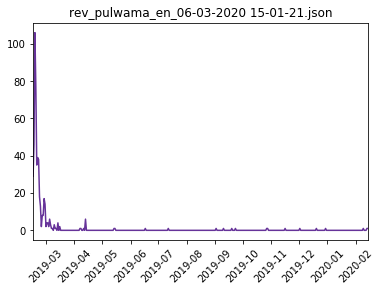

            user  anon  timestamp  size  comment  total
2019-02-15    27     0         27    27       27     27
2019-02-16     5     0          5     5        5      5
2019-02-17     7     3          7     7        7     10
2019-02-18     1     0          1     1        1      1
2019-02-19     0     0          0     0        0      0


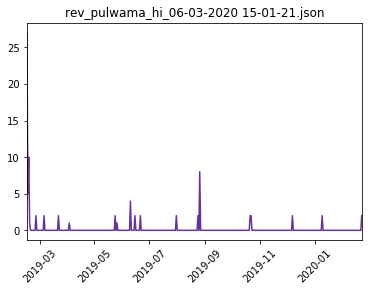

            user  timestamp  size  comment  total
2019-02-15    12         12    12       12     12
2019-02-16    55         55    55       55     55
2019-02-17     4          4     4        4      4
2019-02-18     5          5     5        5      5
2019-02-19     0          0     0        0      0


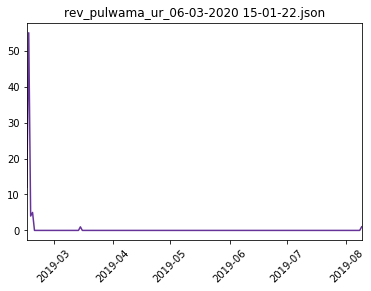

In [9]:
# PULWAMA EDITS

for file in [findfile("rev_pulwama_en"), findfile("rev_pulwama_hi"),
             findfile("rev_pulwama_ur")]:
        edits = getEdits(mypath + file)
        print(edits.head())
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color='rebeccapurple')
        plt.xticks(rotation=45) 
        plt.show()

**``Reorganization of Jammu & Kashmir"** pages

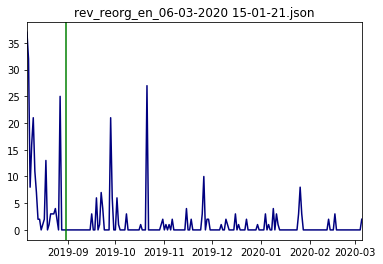

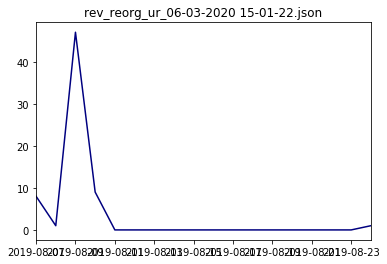

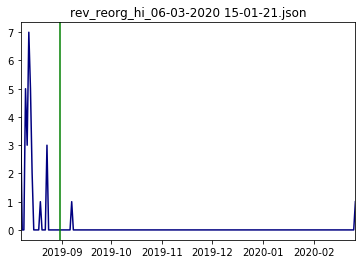

In [10]:
# REORGANISATION EDITS

for file in [findfile("rev_reorg_en"), findfile("rev_reorg_ur"), findfile("rev_reorg_hi")]:
    fig, ax = plt.subplots()
    edits = getEdits(mypath + file)
    #print(edits.head(3))
    #print(edits.tail(3))
    edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color='navy')
    ax.axvline(dt.datetime(2019,8,31), color='g') # vertical line cuz this is the day we sampled text from
    plt.show()

In [11]:
'''for f in os.listdir(mypath):
    if fnmatch.fnmatch(f, 'rev_article_en_*.json'):
        file = f
        
articleEnPath = "../data/revisions/" + file
    
dfEdits = getEdits(articleEnPath)

dfEdits.tail()'''

'for f in os.listdir(mypath):\n    if fnmatch.fnmatch(f, \'rev_article_en_*.json\'):\n        file = f\n        \narticleEnPath = "../data/revisions/" + file\n    \ndfEdits = getEdits(articleEnPath)\n\ndfEdits.tail()'

TLCC plots overlaid
===
...and plots of views vs edits, with significant events. For each article, there is one time-lagged cross-correlation plot (these take into account whole lifespan of article) and a time series plot for each language of just 2019 (edits and page-views).

In [29]:
def corrPlotOverlay(articleName, views, edits, viewsH, editsH, viewsU=None, editsU=None):
    '''
    TIME-LAGGED CROSS-CORRELATION
    -2 week to 2 week lag
    Correlation computed between views per day and edits per day
    We "know" that edits don't lead pageviews, so in a perfect world there would be no correlation to the right of
    center. Interesting results to follow!
    '''
    color = 'orangered'
    
    r = []
    l = []
    d = []
        
    rs = [crosscorr(views, edits, lag) for lag in range(int(-14),int(15))]
    for pearson in rs:
        r.append(pearson)
        l.append('en')
    for lag in range(int(-14),int(15)):
        d.append(lag)
    f,ax=plt.subplots(figsize=(14,3))
    
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    ax.plot(rs, color=color, label='English')
    ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
    ax.set(title='views leads <> edits leads',ylim=[0,1],xlim=[0,28], xlabel='Offset',ylabel='Pearson r')
    # TICKS are -14 to 14: the offsets we set
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.set_xticklabels([-14, -7, 0, 7, 14]);
    
    # Second set
    color = 'maroon'
    rs = [crosscorr(viewsH, editsH, lag) for lag in range(int(-14),int(15))]
    for pearson in rs:
        r.append(pearson)
        l.append('hi')
    for lag in range(int(-14),int(15)):
        d.append(lag)
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    ax.plot(rs, color=color, label='Hindi')
    ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
    
    # Third set
    if viewsU is not None:
        color = 'darkturquoise'
        rs = [crosscorr(viewsU, editsU, lag) for lag in range(int(-14),int(15))]
        for pearson in rs:
            r.append(pearson)
            l.append('ur')
        for lag in range(int(-14),int(15)):
            d.append(lag)
        # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
        offset = np.floor(len(rs)/2)-np.argmax(rs)
        ax.plot(rs, color=color, label='Urdu')
        ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
        
    plt.suptitle(articleName + " correlation between pageviews and edits", y=1.02)
    plt.legend()
    
    plt.savefig("../plots/tlcc/tlcc_" + articleName + ".png")
    
    d = {'lang': l, 'pearson': r, 'offset': d}
    df = pd.DataFrame(data=d)
    return df

'================================================================================================'

def tsViewsEdits(views, edits, lang, article):
    '''
    Just want plot with two time series: edits and views. One call to this fun per language
    '''
    views = views[dt.date(2019,1,1):dt.date(2019,12,1)]# temporary...
    edits = edits[dt.date(2019,1,1):dt.date(2019,12,1)]# temporary...
    # Views
    fig,ax = plt.subplots()
    plt.yscale('log')
    color = "k"
    l1 = ax.plot(views.index, views.views, color=color)
    ax.set_ylabel("Page-views per day", color=color)
    # Edits    
    ax2 = ax.twinx()
    color="tab:orange"
    l2 = ax2.plot(edits.index, edits.total, color=color)
    ax2.set_ylabel("Edits per day", color=color)
    #plt.show()
    if (min(views.index) < dt.date(2019,3,1)): # only if there's data as far back as February
        l3 = ax.axvline(x=dt.date(2019,2,14), color='b',linestyle='--', label='Pulwama Attack')
    l4 = ax.axvline(x=dt.date(2019,8,5), color='c', linestyle='--', label='Revocation of Article 370')
    
    if lang != "urdu":
        ax.legend()
        #ax2.legend()
        
    plt.title(article + " - " + lang)

    plt.savefig("../plots/views_edits/views_edits_" + article + "_ts_"+lang+".png")

* Article 370====================================

**NOTE**: There's something stupid going on that prevents me from getting the whole page-views series for the Urdu version of Article 370. I do have all the data somewhere. Will fix this.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


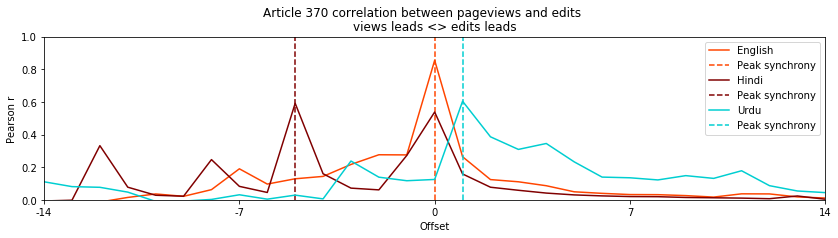

In [13]:
viewsEn = getViews("../data/pageviews/wiki_en_pageviews_2000_thru_Mar2020.csv", "Article 370 of the Constitution of India")
editsEn = getEdits("../data/revisions/" + findfile("rev_article_en"))

viewsHi = getViews("../data/pageviews/wiki_hi_pageviews_2000_thru_Mar2020.csv", "Article 370 of the Constitution of India")
editsHi = getEdits("../data/revisions/" + findfile("rev_article_hi"))

viewsUr = getViews("../data/pageviews/wiki_ur_pageviews_2000_thru_Mar2020.csv", "Article 370 of the Constitution of India")
editsUr = getEdits("../data/revisions/" + findfile("rev_article_ur"))

# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Article 370", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'], viewsUr['views'], editsUr['total'])
pearson_df.to_csv("pearson_corr_article_370.csv", index=False)

# save the figure
plt.savefig("views_edits_article370_corr.eps")

#print(viewsEn.head())

            user  timestamp  size  comment  anon  total
2019-08-13     0          0     0        0     0      0
2019-08-14     0          0     0        0     0      0
2019-08-15     0          0     0        0     0      0
2019-08-16     0          0     0        0     0      0
2019-08-17     0          0     0        0     0      0
...          ...        ...   ...      ...   ...    ...
2019-12-16     0          0     0        0     0      0
2019-12-17     0          0     0        0     0      0
2019-12-18     0          0     0        0     0      0
2019-12-19     0          0     0        0     0      0
2019-12-20     2          2     2        2     0      2

[130 rows x 6 columns]
2018-09-27
False


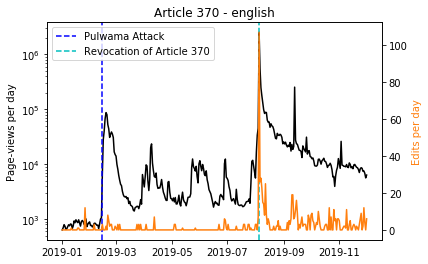

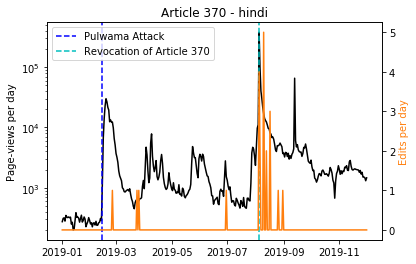

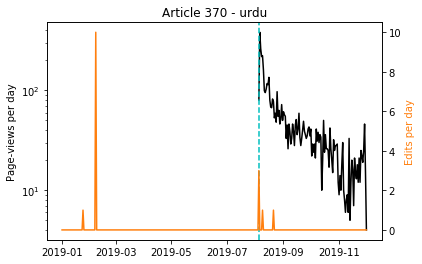

In [14]:
# English
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english", "Article 370")

# Hindi
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi", "Article 370")

# Urdu
editsUr2 = editsUr

editsUr2.set_index(pd.to_datetime(editsUr2.index))

tsViewsEdits(viewsUr, editsUr2, "urdu", "Article 370")

print(editsUr2.tail(130))

print(min(editsUr2.index))
print(min(editsUr2.index) < dt.date(2018,7,5))

* Reorganisation Act===========================

,lang,pearson,offset
0,en,0.133454,-14
1,en,0.125955,-13
2,en,0.129079,-12
3,en,0.106856,-11
4,en,0.107744,-10
...,...,...,...
82,ur,NaN,10
83,ur,NaN,11
84,ur,NaN,12
85,ur,NaN,13


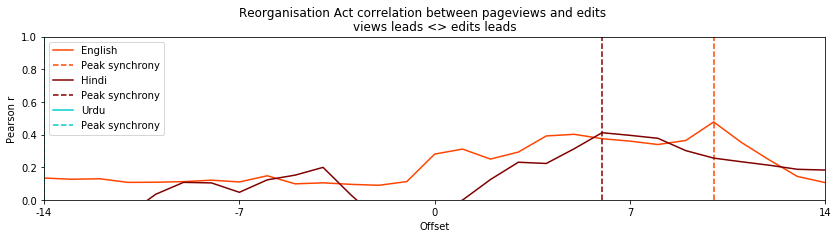

In [30]:
viewsEn = getViews("../data/pageviews/wiki_en_pageviews_2000_thru_Mar2020.csv", "Jammu and Kashmir Reorganisation Act, 2019")
editsEn = getEdits("../data/revisions/" + findfile("rev_reorg_en"))

viewsHi = getViews("../data/pageviews/wiki_hi_pageviews_2000_thru_Mar2020.csv", "Jammu and Kashmir Reorganisation Act, 2019")
editsHi = getEdits("../data/revisions/" + findfile("rev_reorg_hi"))

viewsUr = getViews("../data/pageviews/wiki_ur_pageviews_2000_thru_Mar2020.csv", "Jammu and Kashmir Reorganisation Act, 2019")
editsUr = getEdits("../data/revisions/" + findfile("rev_reorg_ur"))

# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Reorganisation Act", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'], viewsUr['views'], editsUr['total'])

viewsUr.head()
#editsUr.head()
pearson_df

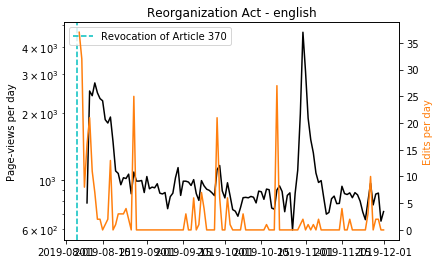

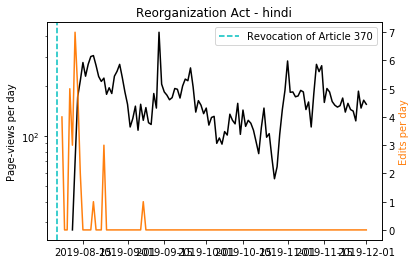

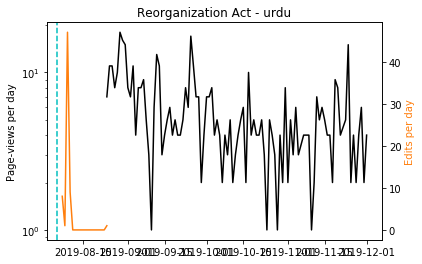

In [16]:
# English
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english", "Reorganization Act")

# Hindi
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi", "Reorganization Act")

# Urdu
editsUr2 = editsUr

editsUr2.set_index(pd.to_datetime(editsUr2.index))

tsViewsEdits(viewsUr, editsUr2, "urdu", "Reorganization Act")

* Pulwama attack===========================

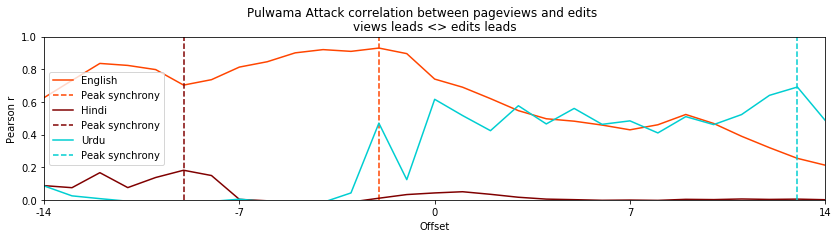

In [17]:
viewsEn = getViews("../data/pageviews/wiki_en_pageviews_2000_thru_Mar2020.csv", "2019 Pulwama attack")
editsEn = getEdits("../data/revisions/" + findfile("rev_pulwama_en"))

viewsHi = getViews("../data/pageviews/wiki_hi_pageviews_2000_thru_Mar2020.csv", "2019 Pulwama attack")
editsHi = getEdits("../data/revisions/" + findfile("rev_pulwama_hi"))

viewsUr = getViews("../data/pageviews/wiki_ur_pageviews_2000_thru_Mar2020.csv", "2019 Pulwama attack")
editsUr = getEdits("../data/revisions/" + findfile("rev_pulwama_ur"))


# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Pulwama Attack", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'], viewsUr['views'], editsUr['total'])

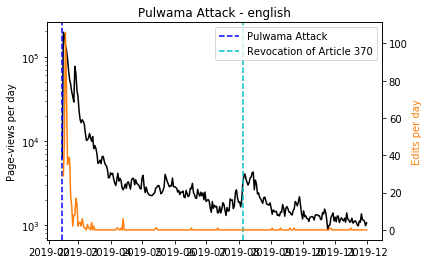

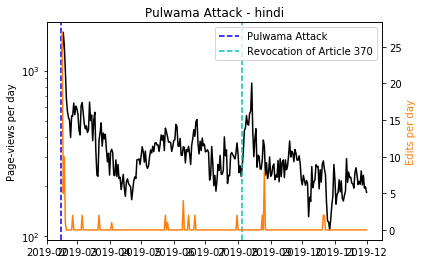

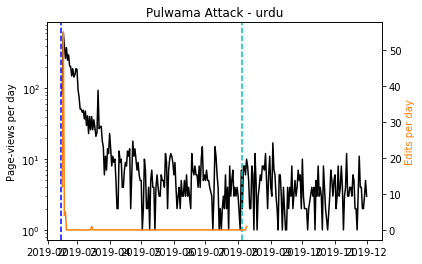

In [18]:
# English
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english", "Pulwama Attack")

# Hindi
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi", "Pulwama Attack")

# Urdu
editsUr2 = editsUr

editsUr2.set_index(pd.to_datetime(editsUr2.index))

tsViewsEdits(viewsUr, editsUr2, "urdu", "Pulwama Attack")

* Kashmir conflict===================================

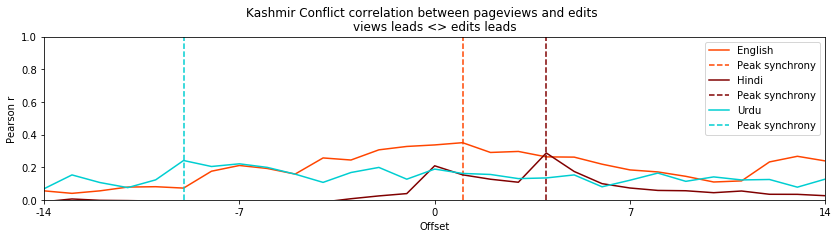

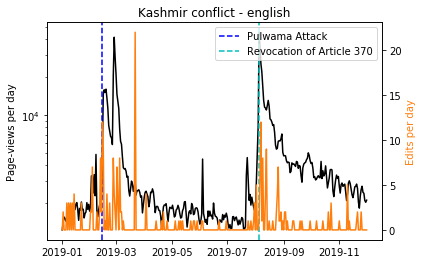

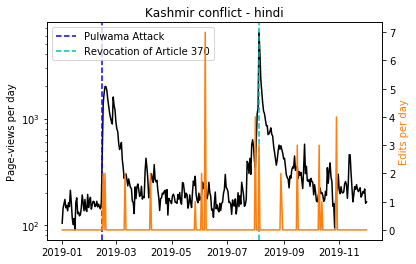

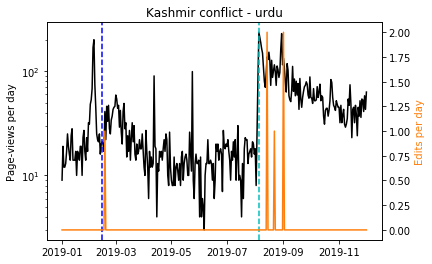

In [19]:
viewsEn = getViews("../data/pageviews/wiki_en_pageviews_2000_thru_Mar2020.csv", "Kashmir conflict")
editsEn = getEdits("../data/revisions/" + findfile("rev_kash_en"))

viewsHi = getViews("../data/pageviews/wiki_hi_pageviews_2000_thru_Mar2020.csv", "Kashmir conflict")
editsHi = getEdits("../data/revisions/" + findfile("rev_kash_hi"))

viewsUr = getViews("../data/pageviews/wiki_ur_pageviews_2000_thru_Mar2020.csv", "Kashmir conflict")
editsUr = getEdits("../data/revisions/" + findfile("rev_kash_ur"))


# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Kashmir Conflict", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'], viewsUr['views'], editsUr['total'])

# English
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english", "Kashmir conflict")

# Hindi
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi", "Kashmir conflict")

# Urdu
editsUr2 = editsUr

editsUr2.set_index(pd.to_datetime(editsUr2.index))

tsViewsEdits(viewsUr, editsUr2, "urdu", "Kashmir conflict")

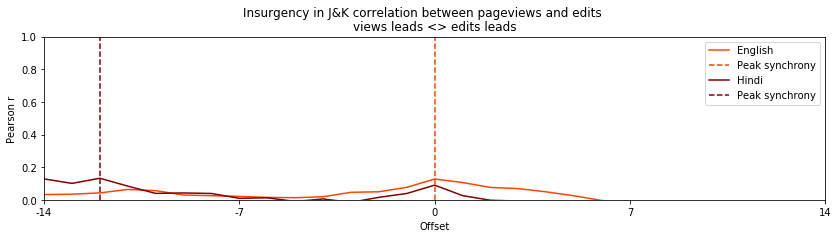

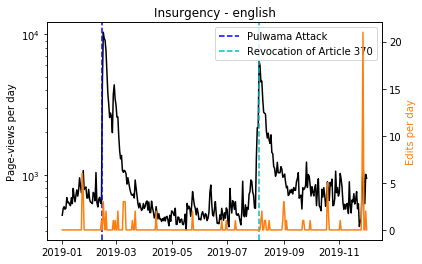

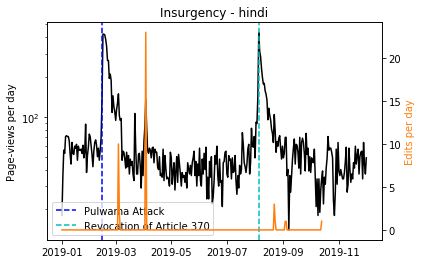

In [31]:
viewsEn = getViews("../data/pageviews/wiki_en_pageviews_2000_thru_Mar2020.csv", "Insurgency in Jammu and Kashmir")
editsEn = getEdits("../data/revisions/" + findfile("rev_insurg_en"))

viewsHi = getViews("../data/pageviews/wiki_hi_pageviews_2000_thru_Mar2020.csv", "Insurgency in Jammu and Kashmir")
editsHi = getEdits("../data/revisions/" + findfile("rev_insurg_hi"))


# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Insurgency in J&K", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'])

# English
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english", "Insurgency")

# Hindi
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi", "Insurgency")